## Importamos las bibliotecas a usar

In [240]:
import kagglehub
from PIL import Image, ImageOps
from itertools import islice
import glob
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import random
from PIL import Image 
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [241]:
device = torch.device("cpu")

<br>
<br>

## Descargamos Dataset

#### Creamos Lista con las rutas a todas las imagenes

En este caso tenemos las imagenes de $29$ peronas, y $13$ selfies
de cada una de estas, por lo que tendremos $377$ imagenes en total.

In [243]:
path = kagglehub.dataset_download("tapakah68/selfies-id-images-dataset")
print("Path to dataset files:", path)

# Solo usamos las selfies
IMAGE_FILES = glob.glob(path + "/**/Selfie*.jpg", recursive=True)
print('Numero de imagenes:', len(IMAGE_FILES))

Path to dataset files: /home/leonel/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5
Numero de imagenes: 377


<br>
<br>

La mayoria de los las imagenes tienen buena resolucion $2300 \times 3088$ pixeles, 
aunque no todos tiene las mismas dimensiones, y ademas son demasiado grandes para los fines
de este proyecto, razones por las cuales les realizaremos una reduccion de escala.

**Si se requiere ver el tamaño real de la imagen se debe descomentar la linea**

```python
#plt.figure(figsize=(width / DPI, height / DPI))
````

ruta del archivo:
 /home/leonel/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5/Selfies ID Images dataset/18_sets_ Caucasians/0001ca9b9a--61ad04a074501f072eccf903_age_20_name_Alessandro/Selfie_4.jpg
Dimensiones: 2320 , 3088


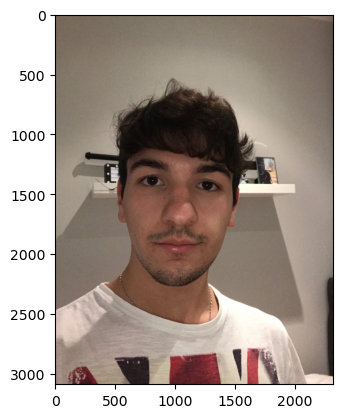

In [244]:
# Abrir la primera imagen
image = ImageOps.exif_transpose(Image.open(IMAGE_FILES[0]))
print('ruta del archivo:\n', IMAGE_FILES[0])
DPI = 96 # pixeles por pulgada
width, height = image.size
#plt.figure(figsize=(width / DPI, height / DPI))  # PARA VER EL TAMA~NO REAL hay que descomentar esta linea <--------------------------------------------
plt.imshow(image)
print('Dimensiones:', width, ',', height)

<br>
<br>

## Reduccion de escala

Si se descomento la linea mencionada se podra ver que en efecto es demasiado grande, por lo que trabajaremos las imagenes con una 
escala reducida, usaremos $\%8$ del tamaño original. 

nuevas dimensiones: 162 , 216


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7988f841db20>
Traceback (most recent call last):
  File "/home/leonel/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/leonel/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/leonel/anaconda3/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonel/anaconda3/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonel/anaconda3/lib/python3.12/multiprocessing/connection.py", line 1135, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonel/anaconda3/lib/pyt

    queue_sem.release()
ValueError: semaphore or lock released too many times
    _threading_Thread_run(self)
  File "/home/leonel/anaconda3/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/leonel/anaconda3/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


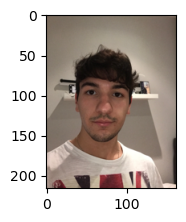

In [245]:
downscaled_width, downscaled_height = int(width * .07) , int(height * .07)
print('nuevas dimensiones:', downscaled_width, ',', downscaled_height)
downscaled_img = image.resize((downscaled_width, downscaled_height))
plt.figure(figsize=(downscaled_width / DPI, downscaled_height / DPI))
plt.imshow(downscaled_img)

In [ ]:
WIDTH, HEIGHT = downscaled_width, downscaled_height

<br>
<br>

## Creacion del dataset supervisado

Para facilitar la creacion del dataset con supervision primiero organizaremos
la lista con las rutas de las imagenes de una forma distinta.

Podemos notar que si dividimos las cadenas con respecto al caracter `/`
la penultima cadena siempre son los datos de la persona y nos puede
servir como identificador.

In [ ]:
IMAGE_FILES[0].split('/')[-2]

'0001ca9b9a--61ad04a074501f072eccf903_age_20_name_Alessandro'

<br>
<br>

**Creamos un diccionario** donde las llaves son el id de la persona
y el valor es el indice de la imagen (en realidad es la ruta absoluta
en el sistema) dentro de

```python
IMAGE_FILES
```


In [ ]:
def organized_dataset(image_files: list[str]) -> dict:
    dataset = {}
    for i, image_full_path in enumerate(image_files):
        person_id = image_full_path.split('/')[-2]
        if person_id not in dataset:
            dataset[person_id] = []
        dataset[person_id].append(i)
    return dataset
    
DATASET = organized_dataset(IMAGE_FILES)
print('Personas:', len(DATASET))

Personas: 29


In [ ]:
def supervised_dataset(dataset: dict) -> tuple[list, list]:
    supervised_ds = []
    all_ids = set(dataset.keys())
    
    for person_id in dataset.keys():
        # computing matching_img, same person
        for j, img_j in enumerate(dataset[person_id]):
            for img_k in islice(dataset[person_id], j + 1, None):
                supervised_ds.append((img_j, img_k, 1))


        # computing mismatching_img, different person
        all_ids.remove(person_id) # temporary remove to compare with others
        for img_i in dataset[person_id]:
            for other_person_id in all_ids:
                mismatched_img = list(map(lambda x: (img_i, x, 0), dataset[other_person_id]))
                supervised_ds.extend(mismatched_img)
        all_ids.add(person_id)

    return supervised_ds
    
SUPERVISED_DATASET = supervised_dataset(DATASET)
print(len(SUPERVISED_DATASET))

139490


In [ ]:
CLASS0 = list(filter(lambda x: x[2] == 0 , SUPERVISED_DATASET))
CLASS1 = list(filter(lambda x: x[2] == 1 , SUPERVISED_DATASET))

In [ ]:
def show_imgs_side_to_side(path_img1: str, path_img2: str, width, height, dpi):
    img1 = ImageOps.exif_transpose(Image.open(path_img1))
    img2 = ImageOps.exif_transpose(Image.open(path_img2))
    
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(img1)
    axes[0].axis('off')  # Desactivar los ejes
    axes[0].set_title("Imagen 1")
    
    axes[1].imshow(img2)
    axes[1].axis('off')  # Desactivar los ejes
    axes[1].set_title("Imagen 2")
    
    plt.tight_layout()
    plt.show()


<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 0 sin reducir

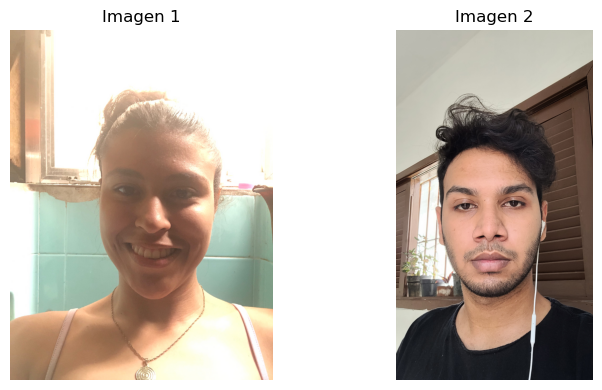

In [ ]:
fst_img_i, snd_img_i, _ = random.choice(CLASS0)
show_imgs_side_to_side(IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i], WIDTH, HEIGHT, DPI)

<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 1 sin reducir

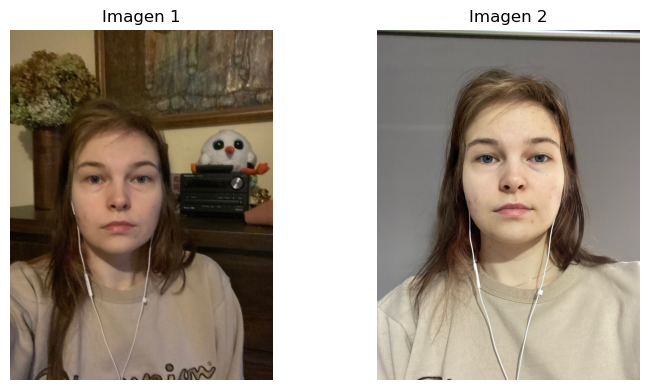

In [ ]:
fst_img_i, snd_img_i, _ = random.choice(CLASS1)
show_imgs_side_to_side(IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i], WIDTH, HEIGHT, DPI)

Una parte del codigo y guia del proyecto se baso por el trabajo de dataHacker en su video y repositorio.
Gracias por compartir este recurso, el cual fue de gran ayuda para el desarrollo de este modelo.

Lo que fue gran parte de su codigo fue en la visualizacion y procesamiento del dataset, aunque fue adaptado a nuestros datos.

repositorio: https://github.com/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb
video: https://www.youtube.com/watch?v=9hLcBgnY7cs&t=296s

In [ ]:
#Reducimos los casos 0 para que sea parejo con la clase1 
CLASS0 = random.sample(CLASS0,220)
CLASS1 = random.sample(CLASS1,220)


CLASS0_TRAIN, CLASS0_EVAL, CLASS1_TRAIN, CLASS1_EVAL = train_test_split(CLASS0,CLASS1, train_size=0.7)
CLASSES_TRAIN = (CLASS0_TRAIN,CLASS1_TRAIN)
CLASSES_EVAL = (CLASS0_EVAL, CLASS1_EVAL)

In [ ]:
#Funciones para mostrar imagenes obtenidas por dataHacker en su proyecto 014_siamseNEtwork
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
# Clase para transformar nuestro dataset en tensores
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageDataset, CLASSES,transform = None): #imageDataset es SUPERVISED_DATASET
        self.imageDataset = imageDataset # Nuestras imagenes
        self.CLASS0, self.CLASS1 = CLASSES  # las tuplas de imagenes de cada clase
        self.transform = transform #Transformacion en donde pasamos la imagen en tensor y tambien modificamos su tamanno
        
    def __getitem__(self, index):
        should_get_same_class = random.randint(0,1) # de forma aleatoria seleccionamos que clase vamos a tomar una tupla
        if should_get_same_class: # Seleccionamos una tupla de la clase que seleccionamos aleatoramente 
            tupledata = random.choice(self.CLASS1) 
        else: 
            tupledata = random.choice(self.CLASS0)

        img0 = Image.open(self.imageDataset[tupledata[0]]) #Abrimos la imagen de la tupla seleccionada del archivo respectivo 
        img1 = Image.open(self.imageDataset[tupledata[1]])

        img0 = ImageOps.exif_transpose(img0)   #Orientamos de manera correcta las imagenes
        img1 = ImageOps.exif_transpose(img1)
        
        img0 = img0.convert("RGB")         
        img1 = img1.convert("RGB")

        if self.transform is not None: # Aplicamos la transformacion 
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([tupledata[2]], dtype=np.float32))
    def __len__(self):
        return len(self.CLASS0) + len(self.CLASS1)

In [ ]:
# Cambiamos el tamanno de las imagenes y las transformamos en tenseres
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Organizamos el dataset para la red
siamese_dataset = SiameseNetworkDataset(imageDataset=IMAGE_FILES,CLASSES=CLASSES_TRAIN,
                                        transform=transformation)

siamese_dataset_eval = SiameseNetworkDataset(imageDataset=IMAGE_FILES,CLASSES=CLASSES_EVAL,
                                        transform=transformation)

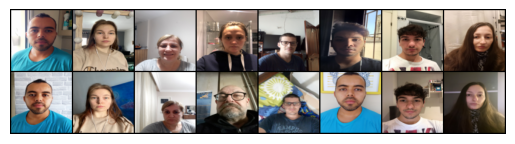

[1. 1. 1. 0. 1. 0. 1. 1.]


In [ ]:

# Creamos un dataloader para visualizar los datos
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# tomamos un batche
example_batch = next(iter(vis_dataloader))

#Concatenamos los pares de imagen para visualizar los datos
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated, nrow=8, padding=2, normalize=True, scale_each=True))
print(example_batch[2].numpy().reshape(-1))

In [ ]:
example_batch[0].shape

torch.Size([8, 3, 100, 100])

[ batch_size, canales RGB, tamanno de la imagen ]

In [ ]:
# Creamos la red 
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        #Dividimos la red en dos partes una convolucional para pasar la imagen a un espacio de caracteristicas
        #en la que podamos obtener una distancia entre dos imagenes, donde si dos imagenes son de la 
        #misma persona entonces se encontraran cerca en el espacio es decir su distancia sera corta y viceversa.
        
        #En la parte convolucional extraemos caracteristicas de las imagenes

        # Capas convolucionales para obtener las caracteristicas de las imagenes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # 3 input porque es rgb el padding mantiene el output 100x100
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        # Max pool para reducir la dimension espacial
        self.pool = nn.MaxPool2d(2, 2) #despues del primer conv + pool ouput pasa de 3x100x100 a 64x50x50
        # en la segunda conv + pool output 128x25x25
        # en la ultima con + pool 256 x 12 x 12

        #Obtenemos una representacion compacta de las caracteristicas de la imagen

        #Combinamos esas caracteristicas para tomar una decision en este caso a un vector para poder compararse
        self.fc1 = nn.Linear(256 * 12 * 12, 1024)  
        self.fc2 = nn.Linear(1024, 128)  
        #Obtenemos una representacion compacta de las caracteristicas de la imagen

        
    def forward_once(self, x):
        # Aplicamos la parte convolucional con relu y en cada una reducimos la dimension
        #F.relu es puramente funcional (no objeto) aplica directamente la activacion
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1) #Aplanamos el resultado para pasarla a la parte fully conneted 256 * 12 * 12 a 36864

         # Obtenemos el embedding
        x = F.relu(self.fc1(x))  #ReLU para que la red aprenda patrones mas complejos
        #fc1 linear toma las caracteristicas obtenidas por la parte convolucional y las procesa para tener caracteristicas de alto nivel
        x = self.fc2(x)  # fc2 linear da el vector final en este caso de tamanno 128 caracteristicas
        return x

    def forward(self, input1, input2):
        
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [ ]:
#La parte importante de siamese networ
#Encontrar la distancia entre las dos imagenes dado el embeding obtenido 
class ContrastiveLoss(torch.nn.Module):
    #El margen es importante porque funciona respecto a nuestro dataset, como veo que son muy distinto, tal vez sea mejor aumentarlo
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculamos la distancia euclidiana entre los dos resultados y luego la perdida
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:

# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [ ]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.01 )

In [ ]:
# Entrenamiento
counter = [] #Variable para poder graficar como cambia la perdida durante las epocas
loss_history = [] 
iteration_number= 0

for epoch in range(100):

    # itermos por batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Mandamos las imagenes al cpu
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Receteamos el gradiente 
        optimizer.zero_grad()

        # Pasamos las imagenes a la red 
        output1, output2 = net(img0, img1)

        # Calculamos la perdida 
        loss_contrastive = criterion(output1, output2, label)

        # Parte de aprendizaje 
        loss_contrastive.backward()

        # Optimizamos
        optimizer.step()

        # Para ver el proceso cada 10 batches
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

KeyboardInterrupt: 

132
tensor([[0.]])


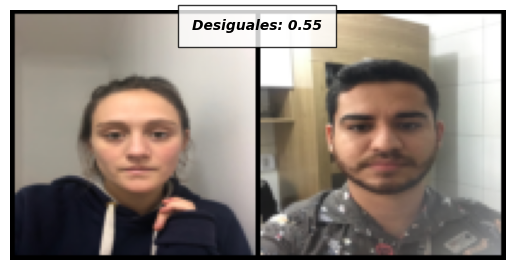

tensor([[0.]])


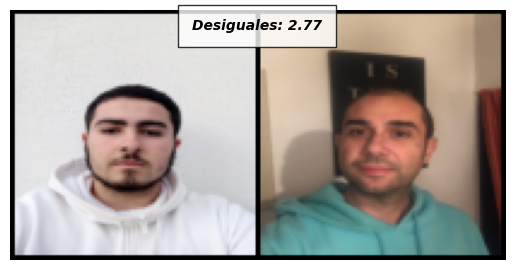

tensor([[1.]])


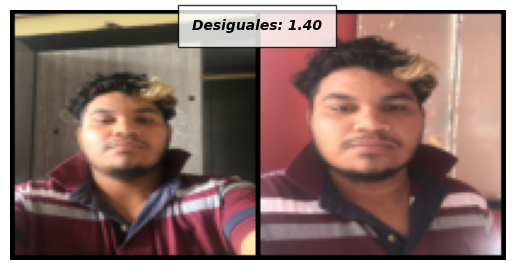

tensor([[0.]])


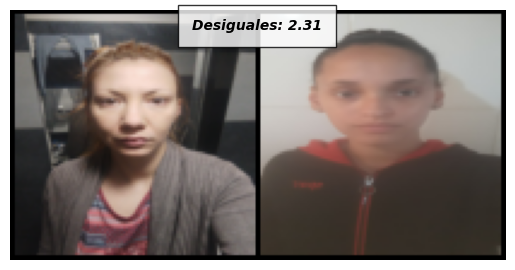

tensor([[0.]])


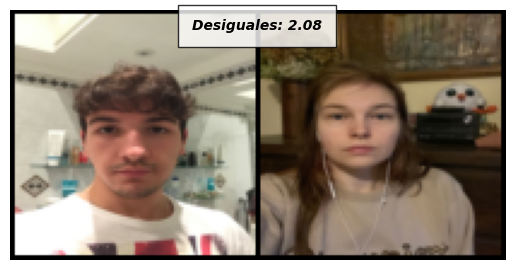

tensor([[1.]])


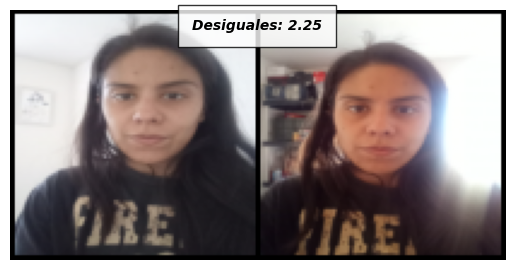

tensor([[1.]])


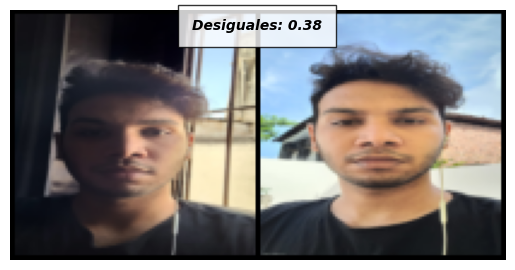

tensor([[1.]])


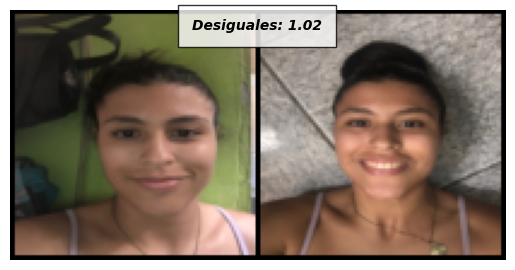

tensor([[1.]])


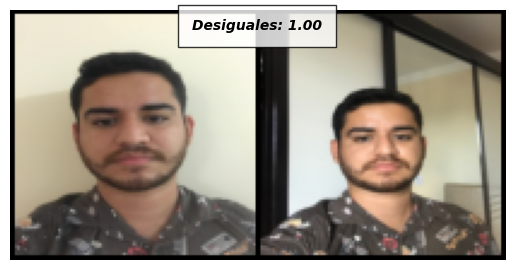

tensor([[0.]])


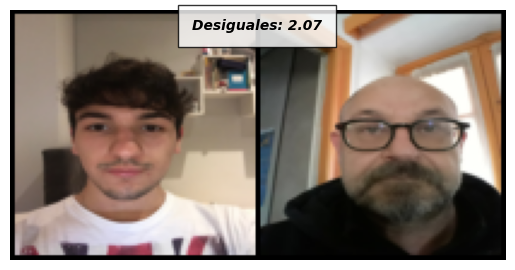

In [ ]:
#Evaluamos 
siamese_dataset_eval = SiameseNetworkDataset(imageDataset=IMAGE_FILES,CLASSES=CLASSES_EVAL,
                                        transform=transformation)
eval_dataloader = DataLoader(siamese_dataset_eval, num_workers=2, batch_size=1, shuffle=True)

#Sacamos una persona con distintas imagenes para ver que tan bien logra diferenciar
dataiter = iter(eval_dataloader)
#x0, _, _ = next(dataiter)
print(len(eval_dataloader))
for i in range(10):
    x0, x1, label2 = next(dataiter)
    print(label2)
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Desiguales: {euclidean_distance.item():.2f}')